# Prototypical Generative Model (PGM) training

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "vae_mnist.ipynb"
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp

import flax
flax.config.update('flax_use_orbax_checkpointing', True)
from flax.training import checkpoints

import ciclo
import wandb 

from clu import parameter_overview
from clu import deterministic_data

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.transformations import transform_image
from experiments.configs.vae_mnist import get_config
from src.utils.input import get_data
from src.models.vae import VAE, create_vae_state, make_vae_train_and_eval, make_vae_plotting_fns
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.training import custom_wandb_logger

/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
ANGLE = 180
config = get_config(f"{ANGLE}")

In [3]:
run = wandb.init(
    project="iclr2024experiments",
    entity="invariance-learners",
    config=config.to_dict(),
    mode="offline",
    notes="VAE testing",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

In [4]:
rng = random.PRNGKey(config.seed)
data_rng, init_rng, state_rng = random.split(rng, 3)

## Get data

In [5]:
jax.local_device_count()

1

In [6]:
train_ds, val_ds, _ = get_data(config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, dro

## Setup TrainState and NN

In [7]:
model = VAE(**config.model.to_dict())

variables = model.init({'params': init_rng, 'sample': init_rng}, jnp.empty((28, 28, 1)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+-------------------------------------------+------------------+---------+-----------+----------+
| Name                                      | Shape            | Size    | Mean      | Std      |
+-------------------------------------------+------------------+---------+-----------+----------+
| params/p_X_given_Z/ConvTranspose_0/bias   | (256,)           | 256     | 0.0       | 0.0      |
| params/p_X_given_Z/ConvTranspose_0/kernel | (3, 3, 3, 256)   | 6,912   | 0.0033    | 0.193    |
| params/p_X_given_Z/ConvTranspose_1/bias   | (128,)           | 128     | 0.0       | 0.0      |
| params/p_X_given_Z/ConvTranspose_1/kernel | (3, 3, 256, 128) | 294,912 | -2.74e-06 | 0.0208   |
| params/p_X_given_Z/ConvTranspose_2/bias   | (64,)            | 64      | 0.0       | 0.0      |
| params/p_X_given_Z/ConvTranspose_2/kernel | (3, 3, 128, 64)  | 73,728  | -6.65e-06 | 0.0294   |
| params/p_X_given_Z/Dense_0/bias           | (256,)           | 256     | 0.0       | 0.0      |
| params/

In [8]:
params = flax.core.freeze(variables["params"])

state = create_vae_state(params, state_rng, config)

train_step, eval_step = make_vae_train_and_eval(model)
x = next(deterministic_data.start_input_pipeline(val_ds))['image'][0]
reconstruction_plot, sampling_plot = make_vae_plotting_fns(config, model, x)

2023-10-03 15:58:13.794536: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


    0/10000 [..............................] - ETA: 0s - elbo: -1029.7286 - ll: -1029.7286 - loss: 1029.7286 - z_kld: 0.0000e+00 - elbo_test: -932.5054 - ll_test: -932.3895 - loss_test: 932.5054 - z_kld_test: 0.0116

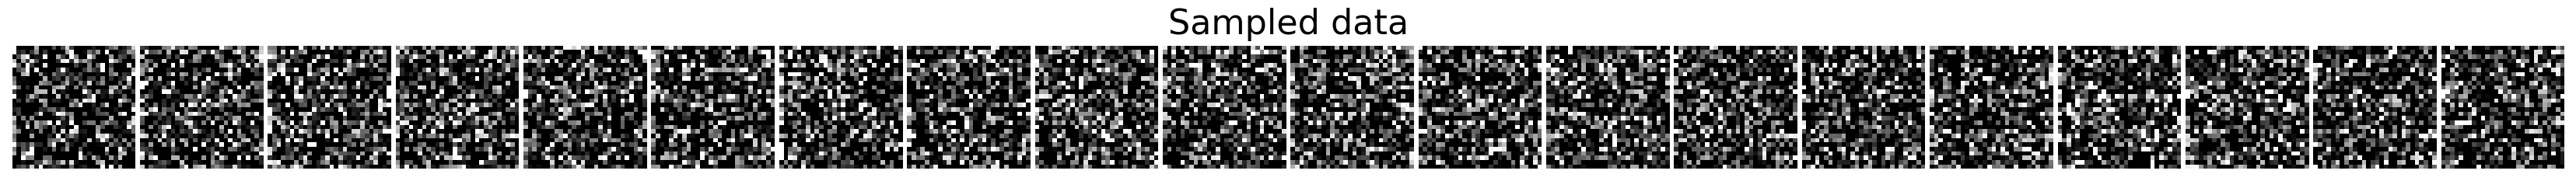

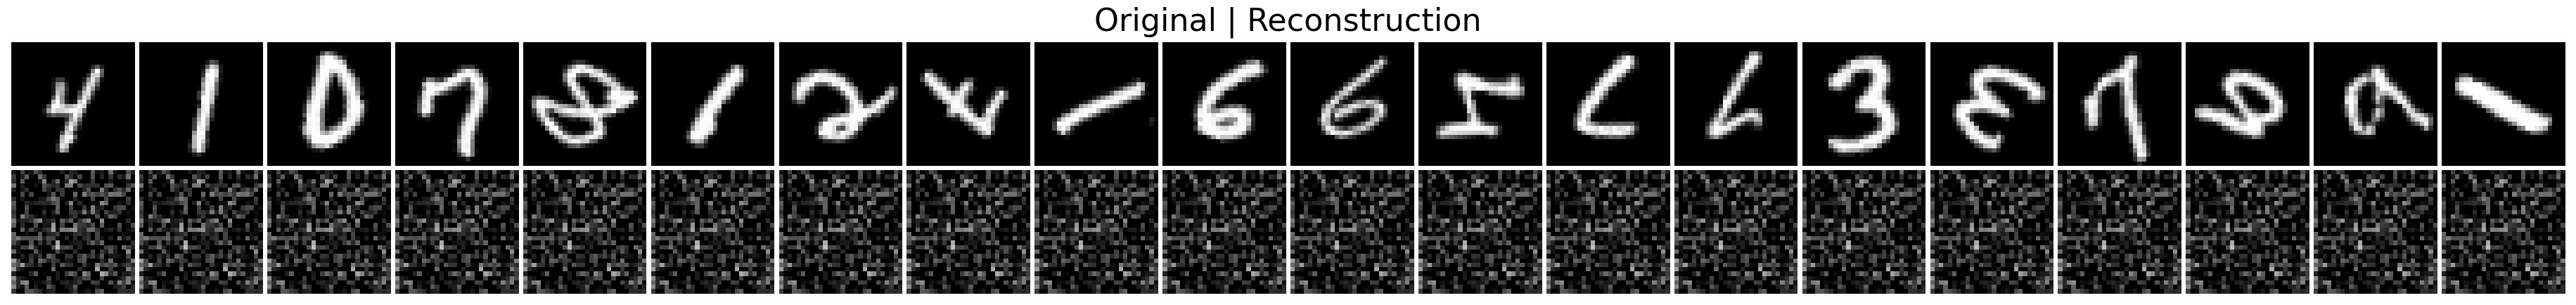

 1000/10000 [==>...........................] - ETA: 12:59 - elbo: -605.4397 - ll: -584.4743 - loss: 605.4397 - z_kld: 2.1392 - elbo_test: -593.3571 - ll_test: -570.7586 - loss_test: 593.3571 - z_kld_test: 2.3107  - ETA: 7:11:51 - elbo: -904.6686 - ll: -904.3442 - loss: 904.6686 - z_kld: 0.0324 - elbo_test: -932.5054 - ll_test: -932.3895 - loss_test: 932.5054 - z_kld_test: 0.0116 - ETA: 5:25:38 - elbo: -893.9261 - ll: -893.5410 - loss: 893.9261 - z_kld: 0.0385 - elbo_test: -932.5054 - ll_test: -932.3895 - loss_test: 932.5054 - z_kld_test: 0.0 - ETA: 3:09:04 - elbo: -872.6232 - ll: -872.2919 - loss: 872.6232 - z_kld: 0.0331 - elbo_test: -932.5054 - ll_test: -932.3895 - loss_test: 932.5054 - z_kld_test: 0.011 - ETA: 2:46:23 - elbo: -867.5541 - ll: -867.2458 - loss: 867.5541 - z_kld: 0.0308 - elbo_test: -932.5054 - ll_test: -932.3895 - loss_test: 932.5054 - z_kld_test: 0.0 - ETA: 2:08:29 - elbo: -857.9146 - ll: -857.6365 - loss: 857.9146 - z_kld: 0.0278 - elbo_test: -932.5054 - ll_test: -9

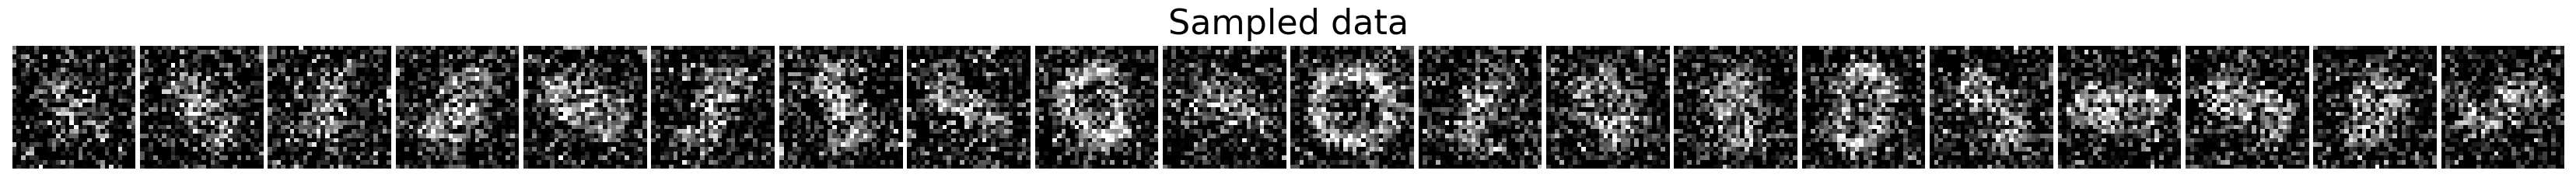

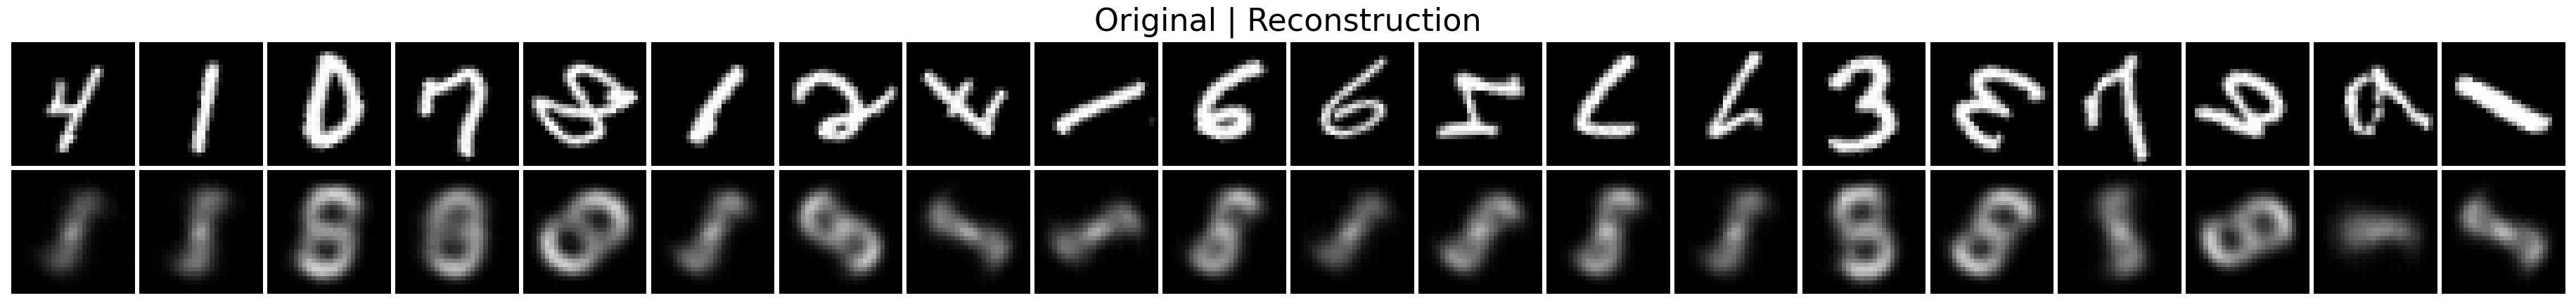

 2000/10000 [=====>........................] - ETA: 10:43 - elbo: -242.2538 - ll: -145.4740 - loss: 242.2538 - z_kld: 10.5411 - elbo_test: -226.8280 - ll_test: -123.6274 - loss_test: 226.8280 - z_kld_test: 11.2904ETA: 13:15 - elbo: -587.2955 - ll: -564.5524 - loss: 587.2955 - z_kld: 2.3259 - elbo_test: -593.3571 - ll_test: -570.7586 - loss_test: 593.3571 - z_kld_test: 2.310 - ETA: 13:14 - elbo: -587.4003 - ll: -564.3762 - loss: 587.4003 - z_kld: 2.3547 - elbo_test: -593.3571 - ll_test: -570.7586 - loss_test: 593.3571 - z_kld_test: 2.310 - ETA: 13:13 - elbo: -586.9867 - ll: -563.7117 - loss: 586.9867 - z_kld: 2.3805 - elbo_test: -593.3571 - ll_test: -570.7586 - loss_test: 593.3571 - z_kld_test: 2.3 - ETA: 13:12 - elbo: -586.4315 - ll: -563.0912 - loss: 586.4315 - z_kld: 2.3874 - elbo_test: -593.3571 - ll_test: -570.7586 - loss_test: 593.3571 - z_kld_test: 2.310 - ETA: 13:11 - elbo: -586.4625 - ll: -563.1402 - loss: 586.4625 - z_kld: 2.3856 - elbo_test: -593.3571 - ll_test: -570.7586 - l

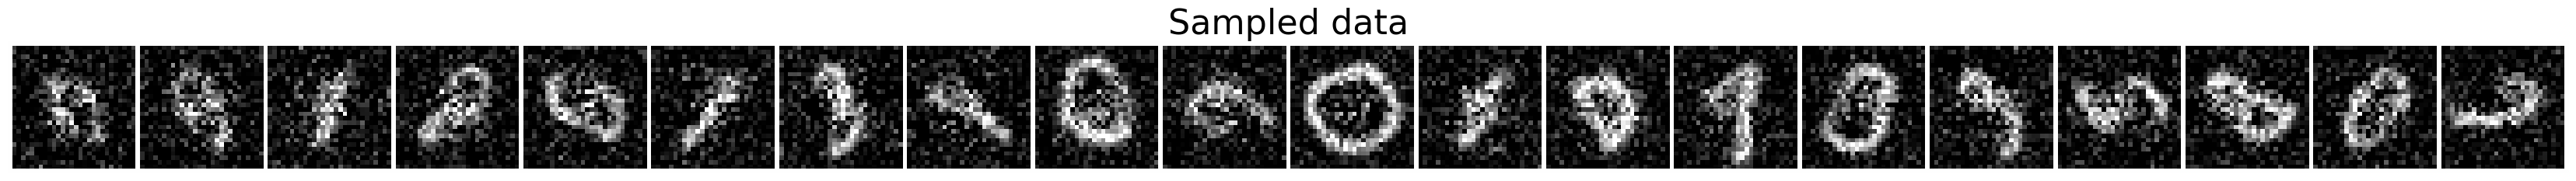

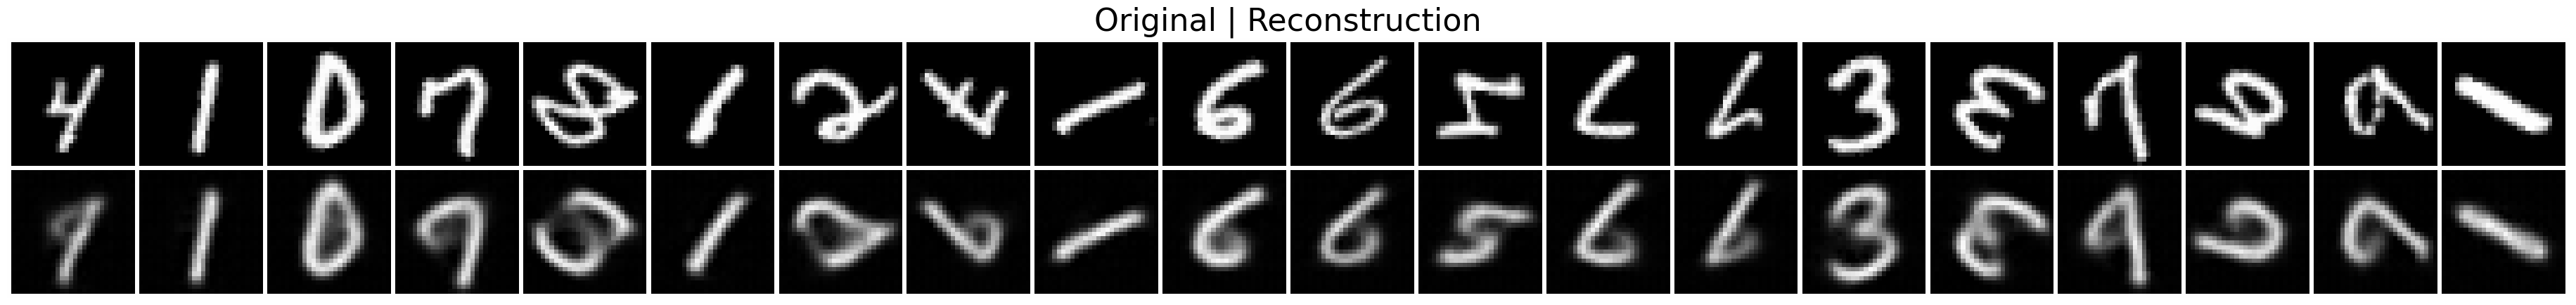

 3000/10000 [========>.....................] - ETA: 9:05 - elbo: 119.5152 - ll: 275.4721 - loss: -119.5152 - z_kld: 19.0144 - elbo_test: 131.5306 - ll_test: 288.5995 - loss_test: -131.5306 - z_kld_test: 19.2840  4- ETA: 10:50 - elbo: -224.8766 - ll: -124.2440 - loss: 224.8766 - z_kld: 11.0114 - elbo_test: -226.8280 - ll_test: -123.6274 - loss_test: 226.8280 - z_kld_test: 11.29 - ETA: 10:50 - elbo: -223.1375 - ll: -122.4856 - loss: 223.1375 - z_kld: 11.0150 - elbo_test: -226.8280 - ll_test: -123.6274 - loss_test: 226.8280 - z_kld_test: 11.29 - ETA: 10:49 - elbo: -222.4674 - ll: -120.7372 - loss: 222.4674 - z_kld: 11.1351 - elbo_test: -226.8280 - ll_test: -123.6274 - loss_test: 226.8280 - z_kld_test: 11.2 - ETA: 10:48 - elbo: -221.4781 - ll: -119.7461 - loss: 221.4781 - z_kld: 11.1379 - elbo_test: -226.8280 - ll_test: -123.6274 - loss_test: 226.8280 - z_kld_test: 11.2 - ETA: 10:47 - elbo: -219.7122 - ll: -117.8518 - loss: 219.7122 - z_kld: 11.1545 - elbo_test: -226.8280 - ll_test: -123.6

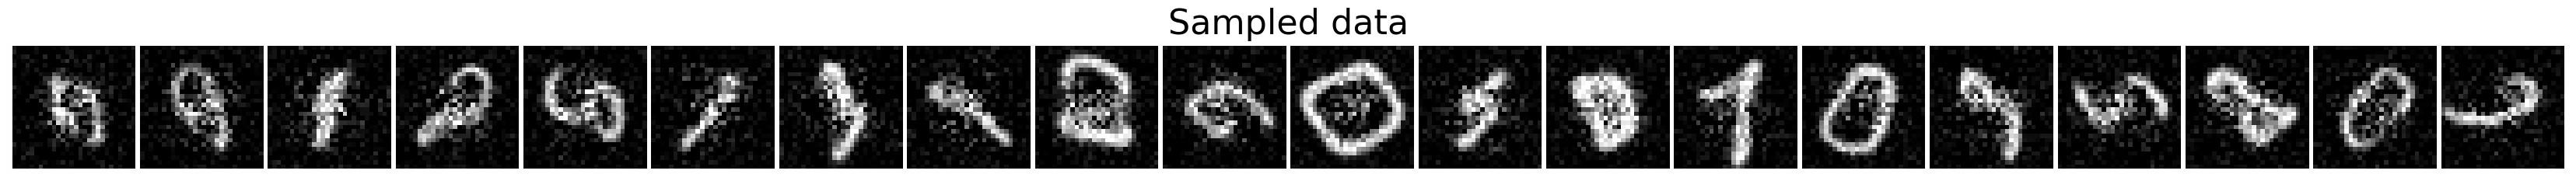

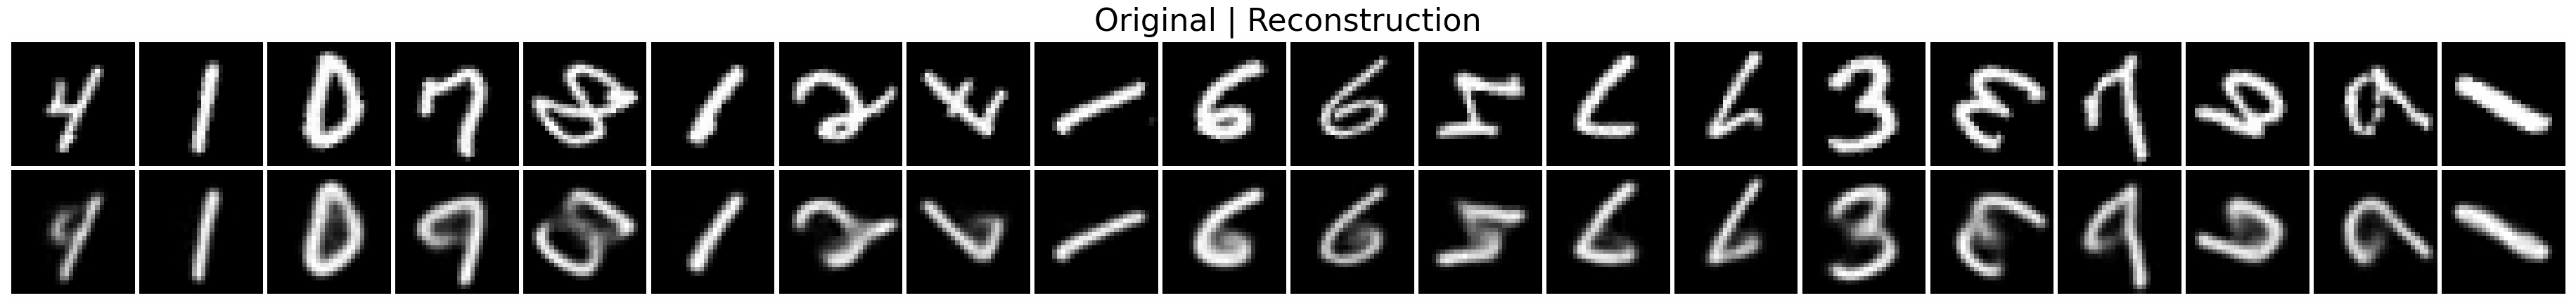

 4000/10000 [===========>..................] - ETA: 7:44 - elbo: 405.8306 - ll: 573.4819 - loss: -405.8306 - z_kld: 24.0949 - elbo_test: 408.9933 - ll_test: 576.9260 - loss_test: -408.9933 - z_kld_test: 24.3713 ETA: 9:09 - elbo: 134.7252 - ll: 292.2149 - loss: -134.7252 - z_kld: 19.3411 - elbo_test: 131.5306 - ll_test: 288.5995 - loss_test: -131.5306 - z_kld_test: 1 - ETA: 9:10 - elbo: 136.1960 - ll: 294.4493 - loss: -136.1960 - z_kld: 19.4418 - elbo_test: 131.5306 - ll_test: 288.5995 - loss_test: -131.5306 - z_kld_test: 19.28 - ETA: 9:10 - elbo: 138.0548 - ll: 295.9968 - loss: -138.0548 - z_kld: 19.4062 - elbo_test: 131.5306 - ll_test: 288.5995 - loss_test: -131.5306 - z_kld_test: 19.28 - ETA: 9:10 - elbo: 137.6958 - ll: 295.3758 - loss: -137.6958 - z_kld: 19.3767 - elbo_test: 131.5306 - ll_test: 288.5995 - loss_test: -131.5306 - z_kld_test: 19.28 - ETA: 9:09 - elbo: 137.9974 - ll: 295.5212 - loss: -137.9974 - z_kld: 19.3602 - elbo_test: 131.5306 - ll_test: 288.5995 - loss_test: -131.

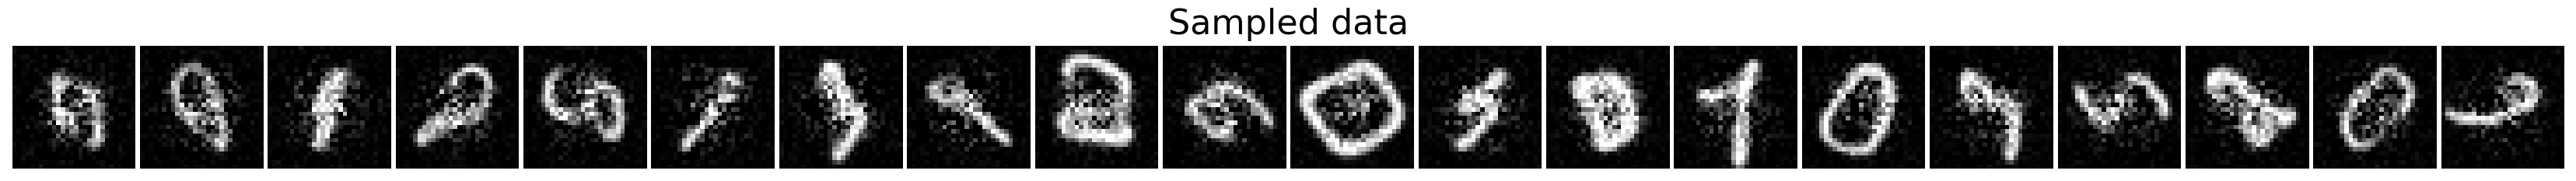

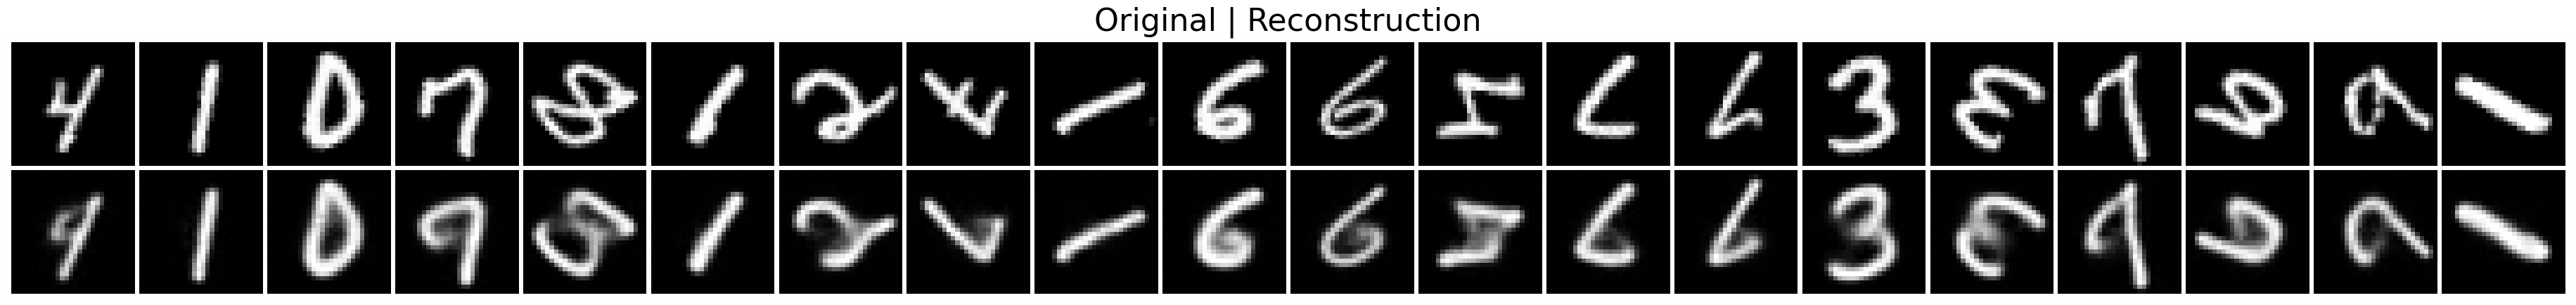

 5000/10000 [==============>...............] - ETA: 6:24 - elbo: 620.9763 - ll: 776.1801 - loss: -620.9763 - z_kld: 27.8581 - elbo_test: 606.0771 - ll_test: 760.5909 - loss_test: -606.0771 - z_kld_test: 28.0934 ETA: 7:46 - elbo: 422.3235 - ll: 589.9418 - loss: -422.3235 - z_kld: 24.3495 - elbo_test: 408.9933 - ll_test: 576.9260 - loss_test: -408.9933 - z_kld_test: 24.37 - ETA: 7:46 - elbo: 422.2395 - ll: 589.6772 - loss: -422.2395 - z_kld: 24.3257 - elbo_test: 408.9933 - ll_test: 576.9260 - loss_test: -408.9933 - z_kld_test: 24. - ETA: 7:46 - elbo: 423.0710 - ll: 590.2786 - loss: -423.0710 - z_kld: 24.2993 - elbo_test: 408.9933 - ll_test: 576.9260 - loss_test: -408.9933 - z_kld_test: 24.37 - ETA: 7:46 - elbo: 423.0789 - ll: 590.3849 - loss: -423.0789 - z_kld: 24.3160 - elbo_test: 408.9933 - ll_test: 576.9260 - loss_test: -408.9933 - z_kld_test: 24. - ETA: 7:45 - elbo: 424.2250 - ll: 591.5272 - loss: -424.2250 - z_kld: 24.3226 - elbo_test: 408.9933 - ll_test: 576.9260 - loss_test: -408.

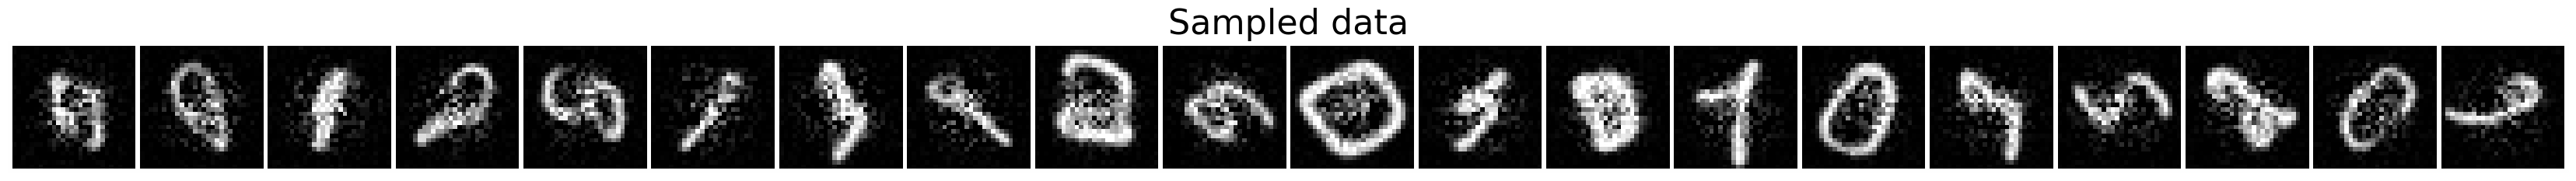

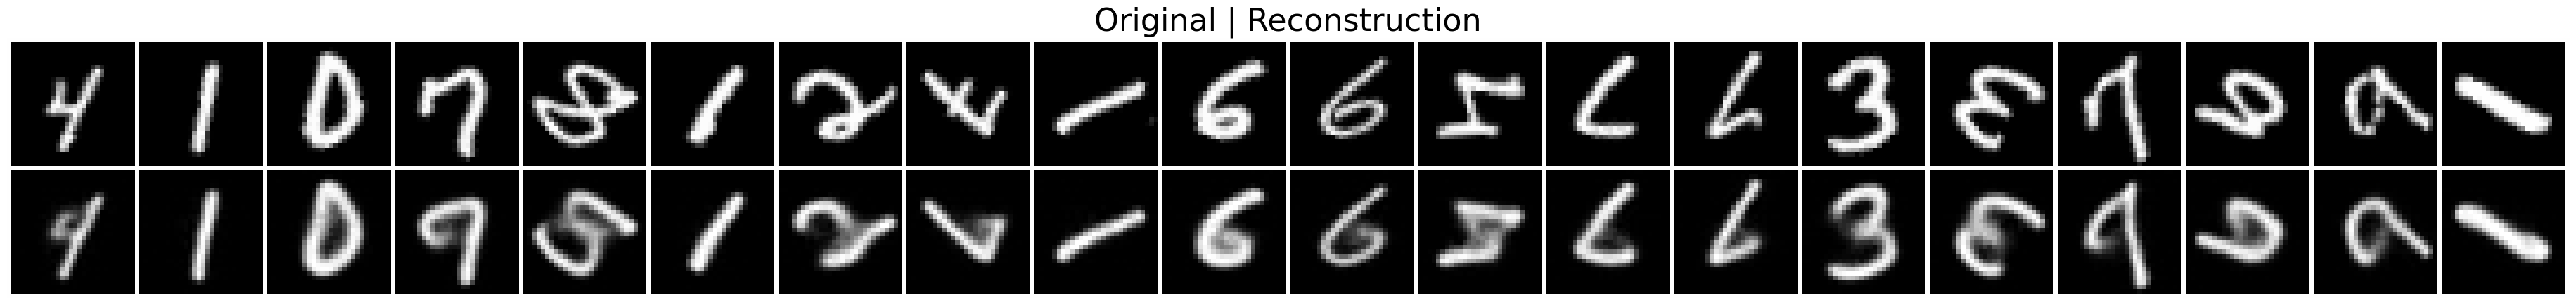

 6000/10000 [=================>............] - ETA: 5:05 - elbo: 772.0475 - ll: 905.1606 - loss: -772.0475 - z_kld: 31.8648 - elbo_test: 734.8751 - ll_test: 866.6893 - loss_test: -734.8751 - z_kld_test: 32.0761 ETA: 6:20 - elbo: 628.6548 - ll: 782.6391 - loss: -628.6548 - z_kld: 28.2075 - elbo_test: 606.0771 - ll_test: 760.5909 - loss_test: -606.0771 - z_kld_test: 28. - ETA: 6:20 - elbo: 629.2832 - ll: 783.2032 - loss: -629.2832 - z_kld: 28.2067 - elbo_test: 606.0771 - ll_test: 760.5909 - loss_test: -606.0771 - z_kld_test: 28.09 - ETA: 6:20 - elbo: 629.5396 - ll: 783.4113 - loss: -629.5396 - z_kld: 28.2051 - elbo_test: 606.0771 - ll_test: 760.5909 - loss_test: -606.0771 - z_kld_test: 28.09 - ETA: 6:19 - elbo: 630.4213 - ll: 784.2600 - loss: -630.4213 - z_kld: 28.2064 - elbo_test: 606.0771 - ll_test: 760.5909 - loss_test: -606.0771 - z_kld_test: 28.09 - ETA: 6:19 - elbo: 630.6060 - ll: 784.4354 - loss: -630.6060 - z_kld: 28.2120 - elbo_test: 606.0771 - ll_test: 760.5909 - loss_test: -60

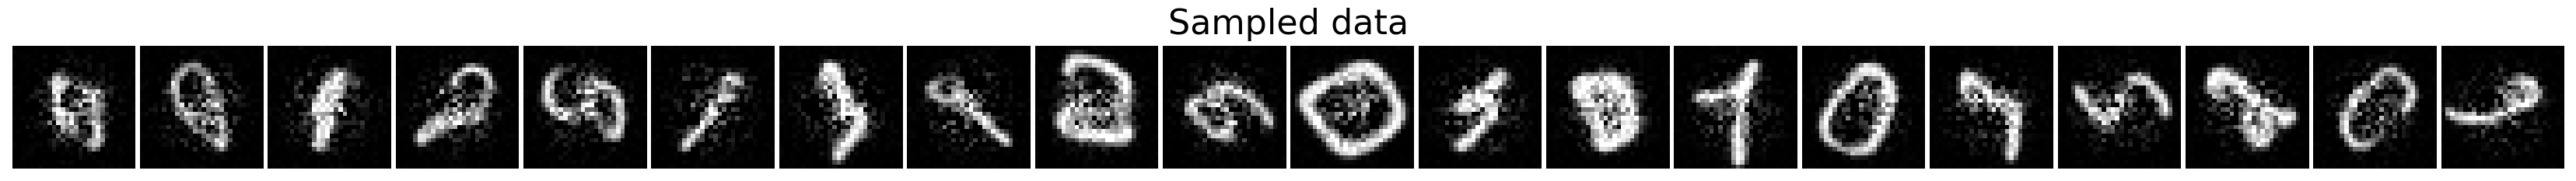

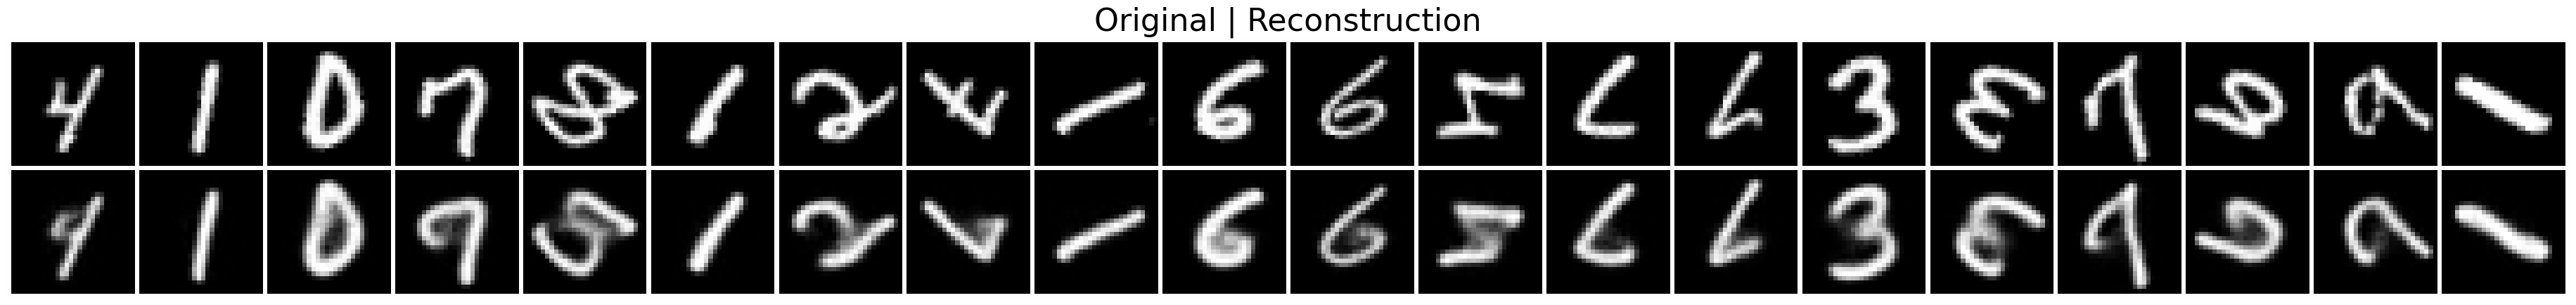

 7000/10000 [====================>.........] - ETA: 3:48 - elbo: 890.6415 - ll: 995.5568 - loss: -890.6415 - z_kld: 36.0161 - elbo_test: 821.6073 - ll_test: 924.8829 - loss_test: -821.6073 - z_kld_test: 36.1741 ETA: 5:06 - elbo: 781.8395 - ll: 914.7404 - loss: -781.8395 - z_kld: 32.3723 - elbo_test: 734.8751 - ll_test: 866.6893 - loss_test: -734.8751 - z_kld_test: 32.07 - ETA: 5:06 - elbo: 782.1404 - ll: 915.0399 - loss: -782.1404 - z_kld: 32.3825 - elbo_test: 734.8751 - ll_test: 866.6893 - loss_test: -734.8751 - z_kld - ETA: 5:05 - elbo: 785.2805 - ll: 916.6800 - loss: -785.2805 - z_kld: 32.0744 - elbo_test: 734.8751 - ll_test: 866.6893 - loss_test: -734.8751 - z_kld_test: 32.07 - ETA: 5:05 - elbo: 785.7433 - ll: 917.1388 - loss: -785.7433 - z_kld: 32.0840 - elbo_test: 734.8751 - ll_test: 866.6893 - loss_test: -734.8751 - z_kld_test: 3 - ETA: 5:05 - elbo: 787.7968 - ll: 919.0066 - loss: -787.7968 - z_kld: 32.0649 - elbo_test: 734.8751 - ll_test: 866.6893 - loss_test: -734.8751 - z_kld

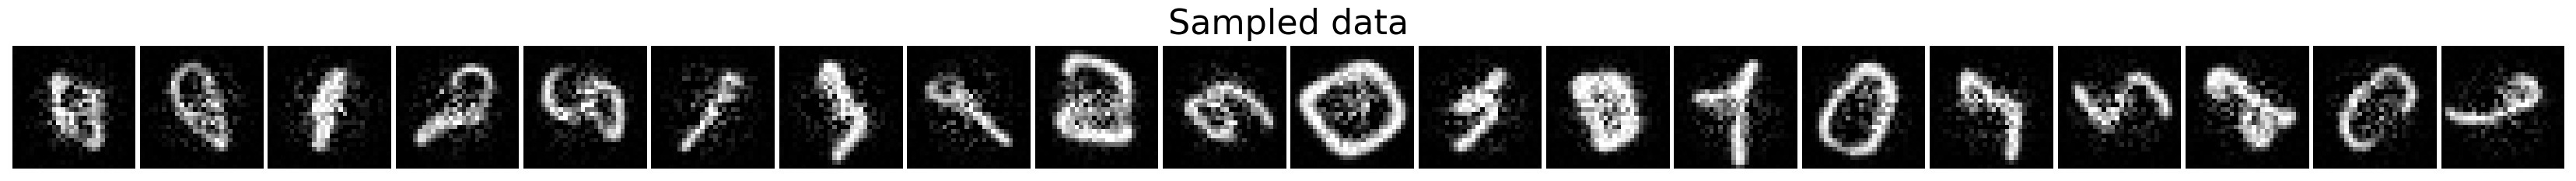

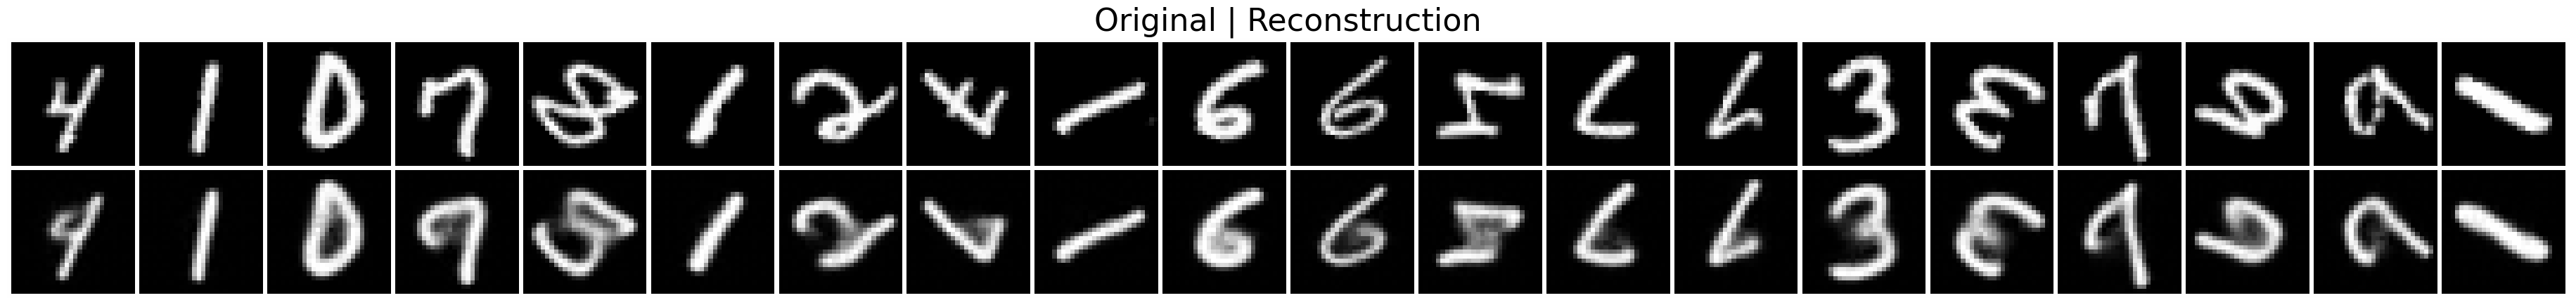

 8000/10000 [=======================>......] - ETA: 2:31 - elbo: 988.7249 - ll: 1065.9706 - loss: -988.7249 - z_kld: 40.6151 - elbo_test: 889.1321 - ll_test: 965.2733 - loss_test: -889.1321 - z_kld_test: 40.9487 ETA: 3:48 - elbo: 902.7789 - ll: 1006.4438 - loss: -902.7789 - z_kld: 36.3396 - elbo_test: 821.6073 - ll_test: 924.8829 - loss_test: -821.6073 - z_kld_test: 36.174 - ETA: 3:48 - elbo: 899.9529 - ll: 1003.7228 - loss: -899.9529 - z_kld: 36.3910 - elbo_test: 821.6073 - ll_test: 924.8829 - loss_test: -821.6073 - z_kld_test: 36.17 - ETA: 3:48 - elbo: 899.7028 - ll: 1003.2986 - loss: -899.7028 - z_kld: 36.3590 - elbo_test: 821.6073 - ll_test: 924.8829 - loss_test: -821.6073 - z_kld_test: 36.174 - ETA: 3:48 - elbo: 902.5296 - ll: 1006.1106 - loss: -902.5296 - z_kld: 36.3684 - elbo_test: 821.6073 - ll_test: 924.8829 - loss_test: -821.6073 - z_kld_test: 36.1 - ETA: 3:47 - elbo: 901.6907 - ll: 1005.4568 - loss: -901.6907 - z_kld: 36.4703 - elbo_test: 821.6073 - ll_test: 924.8829 - loss_

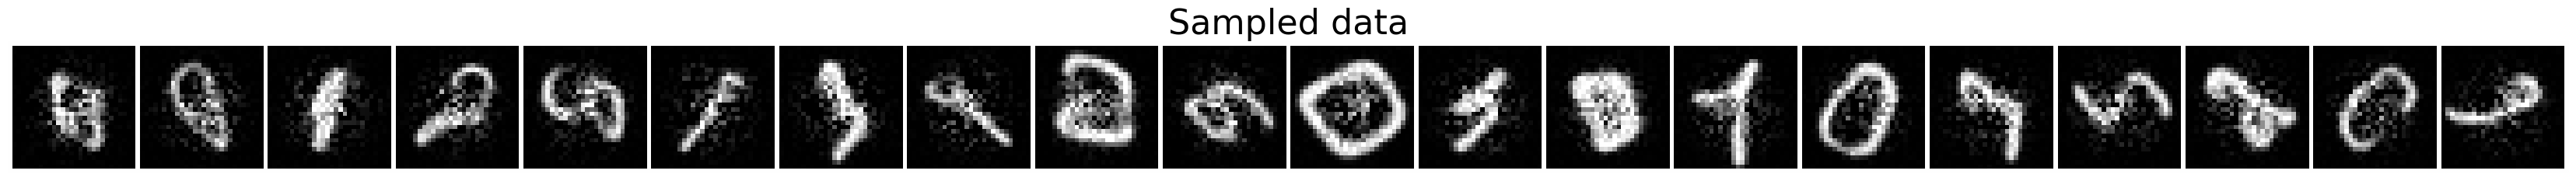

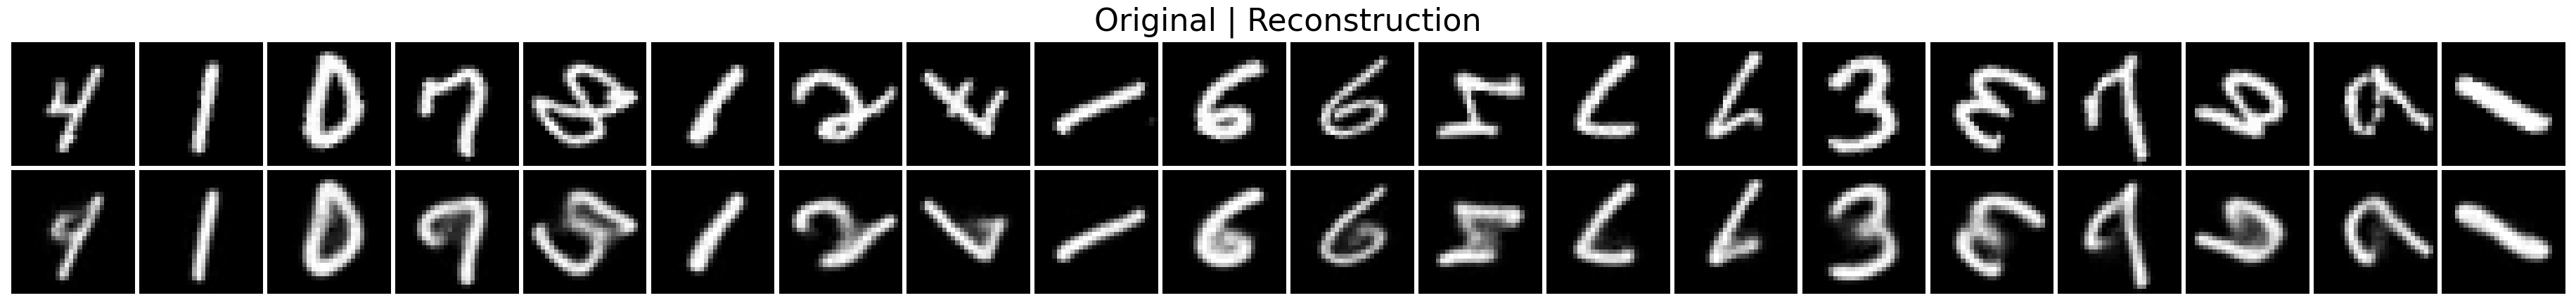

 9000/10000 [==========================>...] - ETA: 1:15 - elbo: 1039.6088 - ll: 1095.6387 - loss: -1039.6088 - z_kld: 45.0765 - elbo_test: 922.9827 - ll_test: 978.2980 - loss_test: -922.9827 - z_kld_test: 45.3311- ETA: 2:31 - elbo: 1005.3564 - ll: 1081.0039 - loss: -1005.3564 - z_kld: 40.7469 - elbo_test: 889.1321 - ll_test: 965.2733 - loss_test: -889.1321 - z_kld_test: 40.948 - ETA: 2:31 - elbo: 1000.8093 - ll: 1076.4127 - loss: -1000.8093 - z_kld: 40.7413 - elbo_test: 889.1321 - ll_test: 965.2733 - loss_test: -889.1321 - z_kld_test: 40.948 - ETA: 2:31 - elbo: 998.2252 - ll: 1073.8743 - loss: -998.2252 - z_kld: 40.7843 - elbo_test: 889.1321 - ll_test: 965.2733 - loss_test: -889.1321 - z_kld_test: 40.9487  - ETA: 2:31 - elbo: 998.3821 - ll: 1073.9963 - loss: -998.3821 - z_kld: 40.7836 - elbo_test: 889.1321 - ll_test: 965.2733 - loss_test: -889.1321 - z_kld_test: 40.948 - ETA: 2:31 - elbo: 995.9297 - ll: 1071.5245 - loss: -995.9297 - z_kld: 40.7915 - elbo_test: 889.1321 - ll_test: 965.

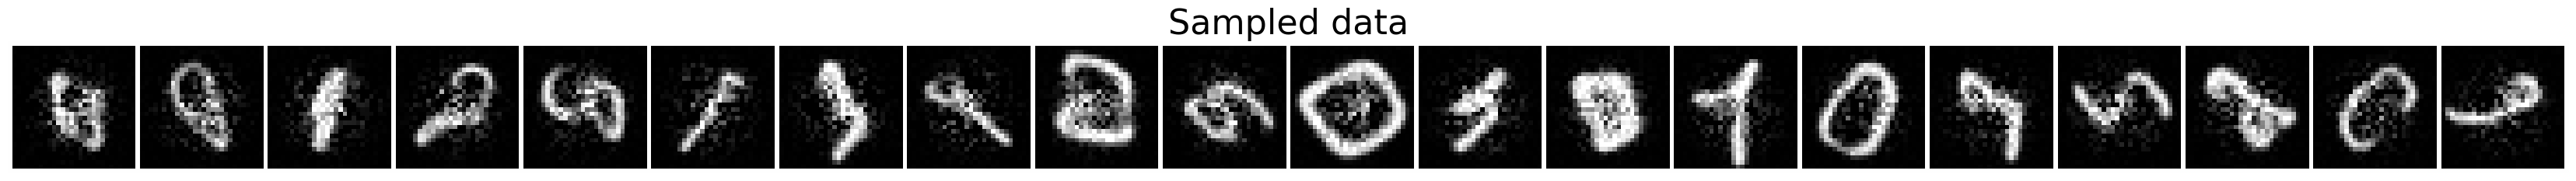

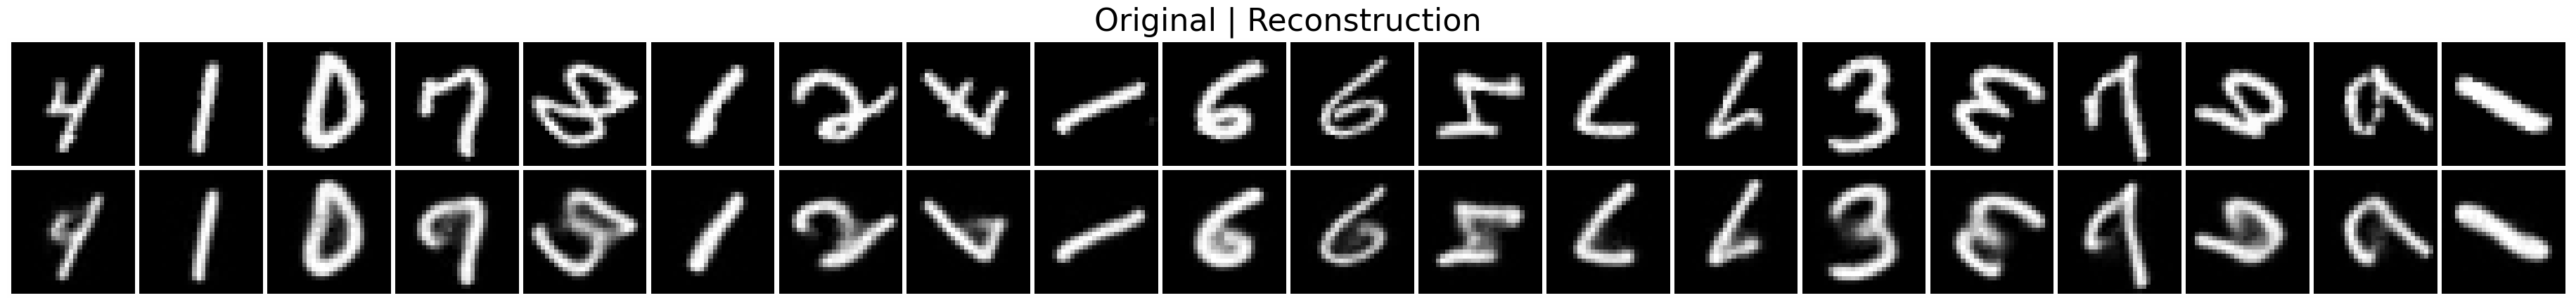

10000/10000 [==============================] - 759s 76ms/step - elbo: 1067.8374 - ll: 1115.7629 - loss: -1067.8374 - z_kld: 47.8897 - elbo_test: 929.4517 - ll_test: 977.5580 - loss_test: -929.4517 - z_kld_test: 48.1069: 1:15 - elbo: 1042.0956 - ll: 1097.4603 - loss: -1042.0956 - z_kld: 45.4043 - elbo_test: 922.9827 - ll_test: 978.2980 - loss_test: -922.9827 - z_kld_test: 45.33 - ETA: 1:15 - elbo: 1039.7540 - ll: 1095.0503 - loss: -1039.7540 - z_kld: 45.3723 - elbo_test: 922.9827 - ll_test: 978.2980 - loss_test: -922.9827 - z_kld_test: 45.3 - ETA: 1:15 - elbo: 1035.0974 - ll: 1090.4724 - loss: -1035.0974 - z_kld: 45.4694 - elbo_test: 922.9827 - ll_test: 978.2980 - loss_test: -922.9827 - z_kld_test: 45.331 - ETA: 1:15 - elbo: 1036.2831 - ll: 1091.6390 - loss: -1036.2831 - z_kld: 45.4619 - elbo_test: 922.9827 - ll_test: 978.2980 - loss_test: -922.9827 - z_kld_test: 45.33 - ETA: 1:14 - elbo: 1035.5255 - ll: 1090.7413 - loss: -1035.5255 - z_kld: 45.3788 - elbo_test: 922.9827 - ll_test: 978.

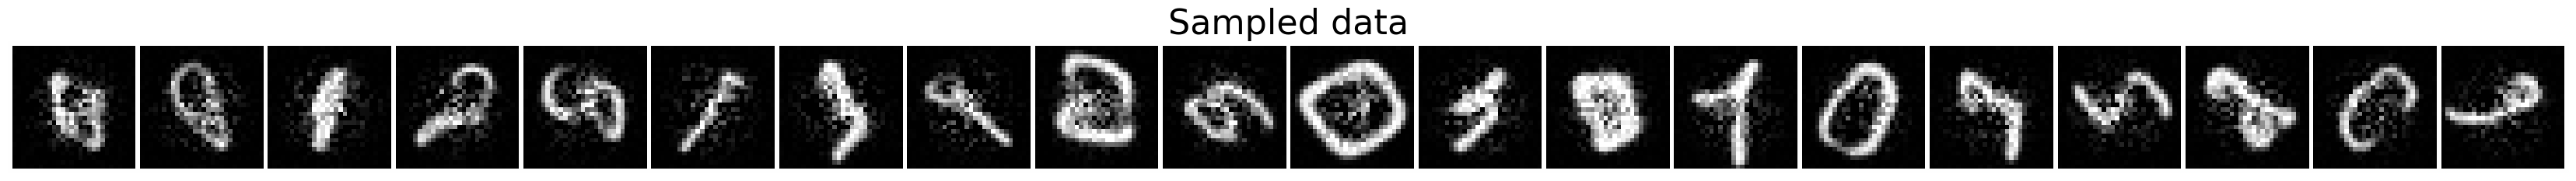

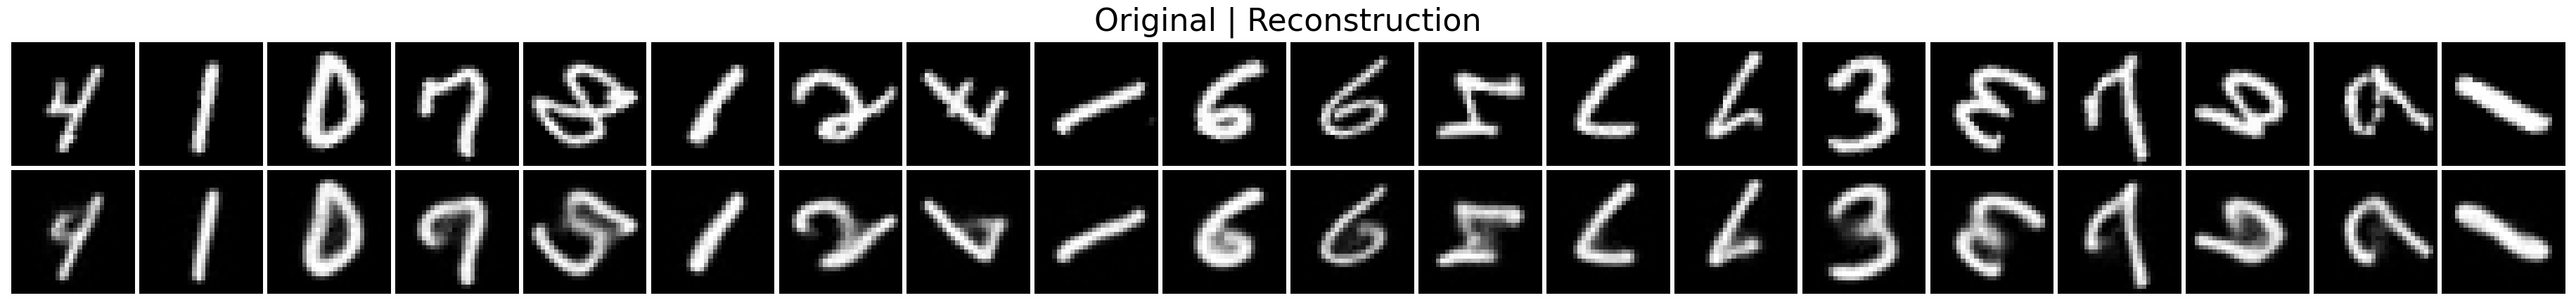

In [9]:
final_state, history, _ = ciclo.train_loop(
    state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.every(int(config.steps * config.plot_freq)): [
            sampling_plot,
            reconstruction_plot,
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: [
            eval_step,
        ],
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(config.steps * config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=config.steps),
    ],
    stop=config.steps + 1,
)

In [10]:
run.finish()

lr,▂▃▅▆██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/elbo,▁▁▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
train/ll,▁▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████████████
train/loss,████▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/z_kld,▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
valid/elbo,▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████
valid/ll,▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇█████████████████
valid/loss,█▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/z_kld,▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
β,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
lr,0.0003


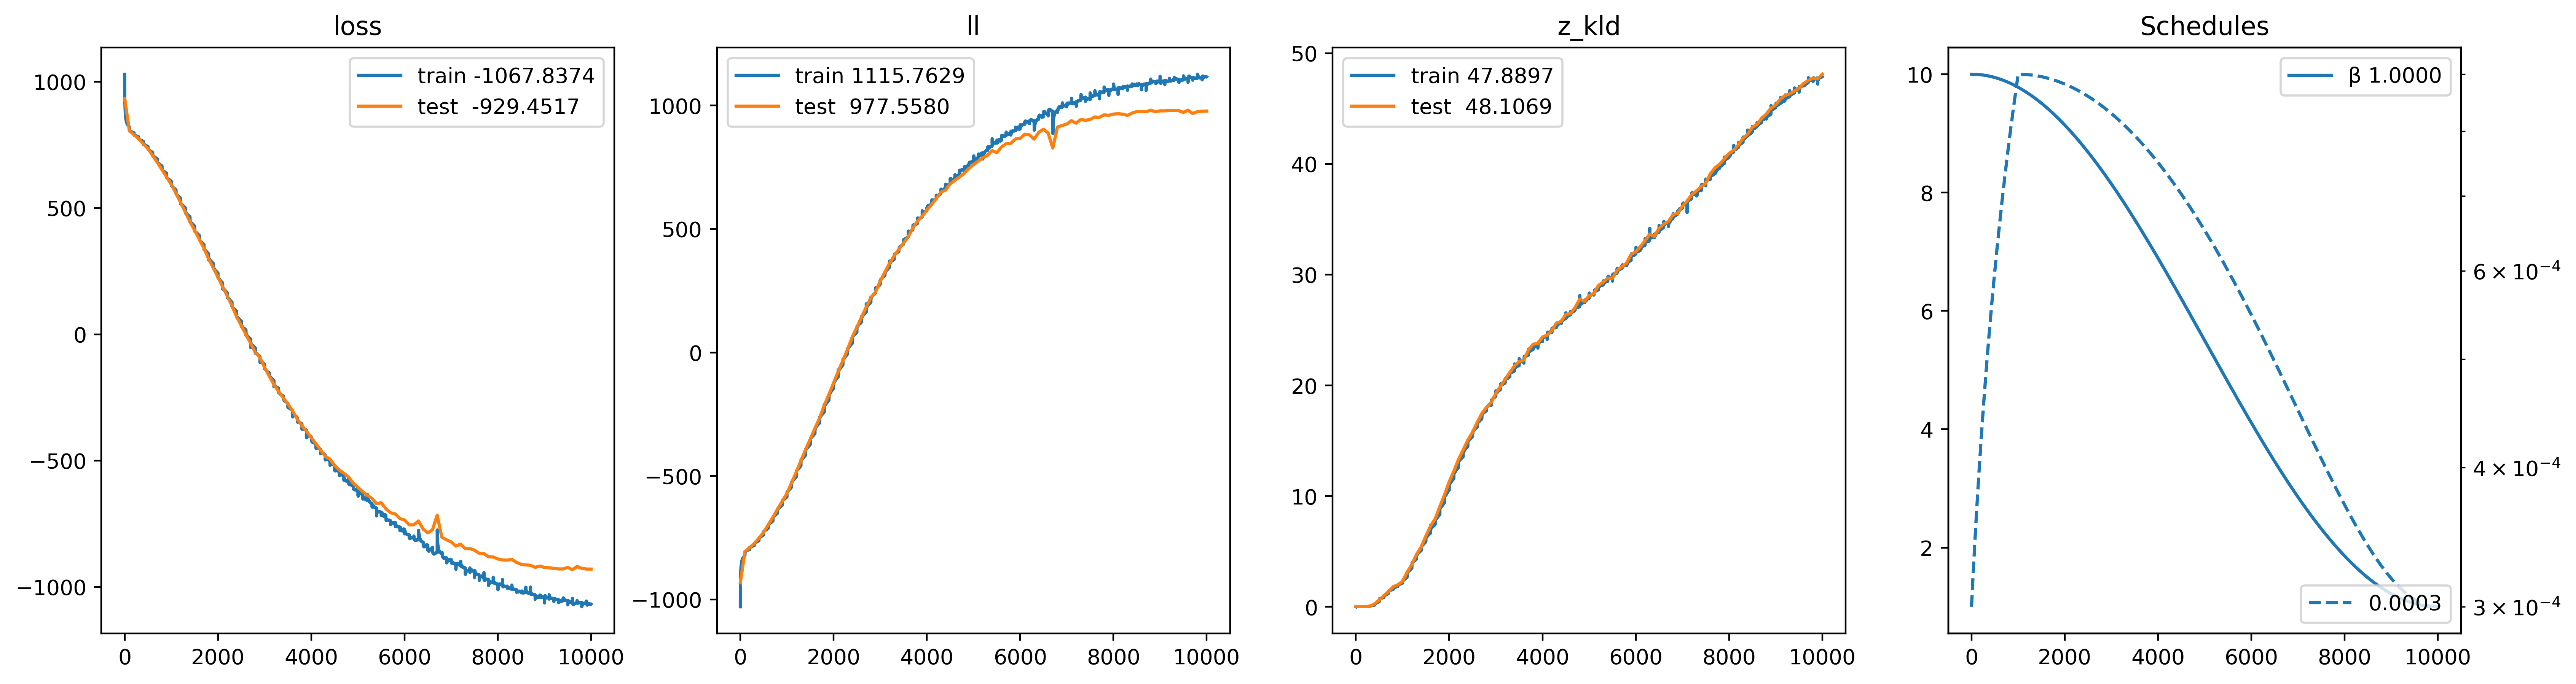

In [11]:
# plot the training history
steps, loss, elbo, ll, z_kld, lr, β = history.collect(
    "steps", "loss", "elbo", "ll", "z_kld", "lr", "β"
)
steps_test, loss_test, elbo_test, ll_test, z_kld_test = history.collect(
    "steps", "loss_test", "elbo_test", "ll_test", "z_kld_test"
)

n_plots = 4
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, ll, label=f"train {ll[-1]:.4f}")
axs[1].plot(steps_test, ll_test, label=f"test  {ll_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("ll")

axs[2].plot(steps, z_kld, label=f"train {z_kld[-1]:.4f}")
axs[2].plot(steps_test, z_kld_test, label=f"test  {z_kld_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("z_kld")

axs[3].plot(steps, β, label=f"β {β[-1]:.4f}")
axs[3].legend()
axs[3].set_title("Schedules")

ax3_twin = axs[3].twinx()
ax3_twin.plot(steps, lr, "--", label=f"{lr[-1]:.4f}")
ax3_twin.legend(loc="lower right")
ax3_twin.set_yscale("log")

plt.show()